In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Neural network required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# model evaluation libraries
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#for saving trained model
import pickle

import warnings
warnings.filterwarnings("ignore") # To prevent kernel from showing any warning

In [2]:
dataset = pd.read_excel("airlines.xlsx")
dataset. head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [3]:
# converting Month column to datetime format
dataset["Month"] = dataset["Month"]. dt. strftime('%b-%y')

In [4]:
# changing index to datetime
dataset. set_index(["Month"], inplace = True)

In [5]:
dataset. head()

,Passengers
Month,
Jan-95,112
Feb-95,118
Mar-95,132
Apr-95,129
May-95,121


In [6]:
df = dataset. copy()

In [23]:
df. shape

(96, 1)

In [7]:
df. head()

,Passengers
Month,
Jan-95,112
Feb-95,118
Mar-95,132
Apr-95,129
May-95,121


In [8]:
df.index.min(), df.index.max()

('Apr-00', 'Sep-99')

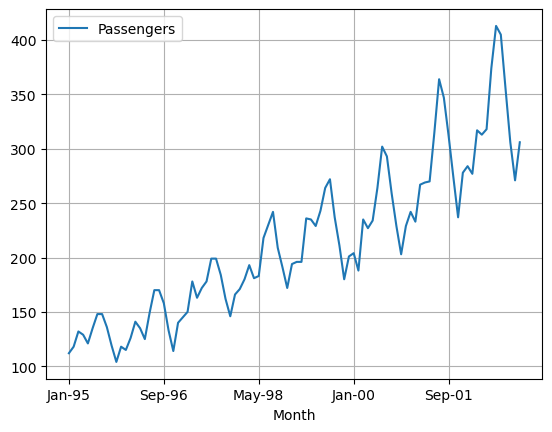

In [9]:
df.plot(grid=True);

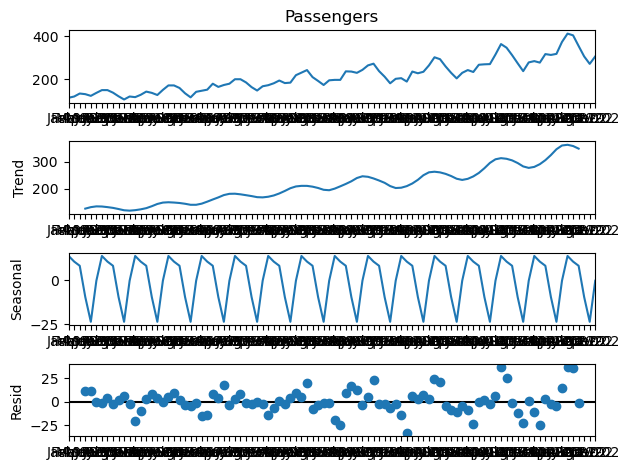

In [14]:
decompose_add = seasonal_decompose(df['Passengers'], period = 6)
decompose_add.plot();

**Stationary Time Series :**   
A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict

Sign of obvious trends, seasonality, or other systematic structures in the series are indicators of a non-stationary series. A more accurate method would be to use a statistical test, such as the Dickey-Fuller test.

**ADFuller Test:**  
If Test statistic < Critical Value and p-value < 0.05 – then series is stationary

In [15]:
# functon for adf test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print ('----------------------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print (adf_output)
    
# calling adf function and passing series
adf_test(df.values)

Results of Dickey-Fuller Test:
----------------------------------------------
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


The p-value obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. Hence the series is not stationary 
**Differencing :**  
Differencing is a method of transforming a time series dataset. Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.

Depending on the number of diferencing required to make series stationary,we get value of 'd'. Which is a required parameter in ARIMA model

In [16]:
diff_df = df.diff() #first differencing for stationarity
diff_df.head()

,Passengers
Month,
Jan-95,NaN
Feb-95,6.0
Mar-95,14.0
Apr-95,-3.0
May-95,-8.0


In [17]:
# depending on your differenced order you might have 1,2 or 3 null values, remove those
diff_df.dropna(inplace=True) 

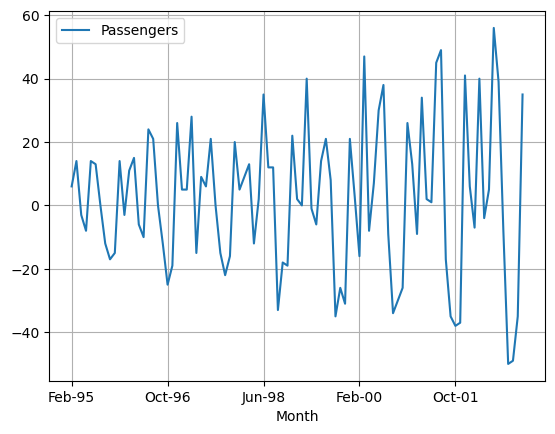

In [18]:
diff_df.plot(grid=True);

In [19]:
# call the adf_test function and pass differenced series
adf_test(diff_df)

Results of Dickey-Fuller Test:
----------------------------------------------
Test Statistic                 -2.150002
p-value                         0.224889
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


**Autocorrelation and Partial Autocorrelation Function:**  
Autocorrelation and partial autocorrelation are plots that graphically summarize the impact of observations at prior timesteps on the observations we are trying to predict.

**ACF plot gives the q value and PACF gives the p value**  
Look for tail of pattern in either ACF or PACF. If tail is crossing the blue region then it will give us potential p and q values.

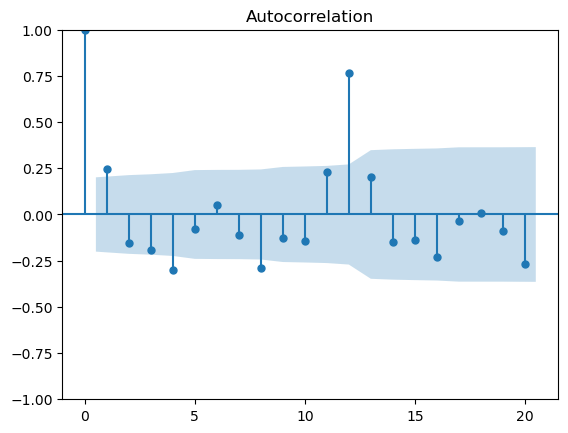

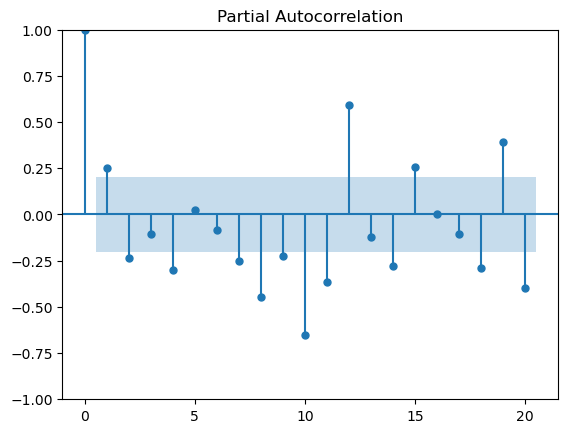

In [20]:
# if the series is not stationary then make sure to pass differenced series instead of original series
plot_acf(diff_df);
plot_pacf(diff_df);

1.From ACF plot we can see that q values can be 1,4,8,12,
2.From PACF plot we can see that p values can be 1,2,4,6,7,8,9,10,11,12,14,15

LSTM stands for Long short-term memory. LSTM cells are used in recurrent neural networks that learn to predict the future from sequences of variable lengths. Note that recurrent neural networks work with any kind of sequential data and, unlike ARIMA and Prophet, are not restricted to time series. 

Designing an optimal LSTM based model can be a difficult task that requires careful hyperparameter tuning.

In [36]:
#split the data into train and test
size = int(len(df)*0.80)
#splitting the first 70% data zto train and the rest to test

In [37]:
train_df = df[:size]
train_df.tail()

,Passengers
Month,
Dec-00,229
Jan-01,242
Feb-01,233
Mar-01,267
Apr-01,269


In [38]:
test_df = df[size:]
test_df.head()

,Passengers
Month,
May-01,270
Jun-01,315
Jul-01,364
Aug-01,347
Sep-01,312


In [39]:
train_df. shape

(76, 1)

In [40]:
test_df. shape

(20, 1)

In [21]:
def df_to_x_y(df, window_size):
    df_as_np = df.to_numpy()
    x=[]
    y=[]
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(x), np.array(y)

In [24]:
x, y = df_to_x_y(df['Passengers'], 12)
x.shape, y.shape

((84, 12, 1), (84,))

In [42]:
x_train_df, y_train_df = x[:-20], y[:-20]
x_test_df, y_test_df = x[-20:], y[-20:]
x_train_df.shape, y_train_df.shape, x_test_df.shape, y_test_df.shape

((64, 12, 1), (64,), (20, 12, 1), (20,))

In [43]:
lstm = Sequential()
lstm.add(InputLayer((12,1)))
lstm.add(LSTM(20))
lstm.add(Dense(10,'relu'))
lstm.add(Dense(5,'relu'))
lstm.add(Dense(1,'linear'))

lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20)                1760      
                                                                 
 dense_9 (Dense)             (None, 10)                210       
                                                                 
 dense_10 (Dense)            (None, 5)                 55        
                                                                 
 dense_11 (Dense)            (None, 1)                 6         
                                                                 
Total params: 2,031
Trainable params: 2,031
Non-trainable params: 0
_________________________________________________________________


In [49]:
cp1 = ModelCheckpoint('lstm/', save_best_only=True)
lstm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])

In [45]:
lstm.fit(x_train_df, y_train_df, epochs=100, callbacks=[cp1])

Epoch 1/100
2/2 [==============================] - 2s 6ms/step - loss: 40999.1562 - root_mean_squared_error: 202.4825
Epoch 2/100
2/2 [==============================] - 0s 7ms/step - loss: 40202.3945 - root_mean_squared_error: 200.5053
Epoch 3/100
2/2 [==============================] - 0s 7ms/step - loss: 38806.5352 - root_mean_squared_error: 196.9937
Epoch 4/100
2/2 [==============================] - 0s 7ms/step - loss: 36212.7344 - root_mean_squared_error: 190.2964
Epoch 5/100
2/2 [==============================] - 0s 7ms/step - loss: 32418.3066 - root_mean_squared_error: 180.0508
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 26940.7812 - root_mean_squared_error: 164.1365
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 20008.1602 - root_mean_squared_error: 141.4502
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 12468.2266 - root_mean_squared_error: 111.6612
Epoch 9/100
2/2 [==============================] - 0s 7m

In [ ]:
# here we need more data to train our model

In [46]:
test_predictions = lstm.predict(x_test_df).flatten()
test_df['lstm_pred'] = test_predictions

1/1 [==============================] - 1s 773ms/step


<AxesSubplot: xlabel='Month'>

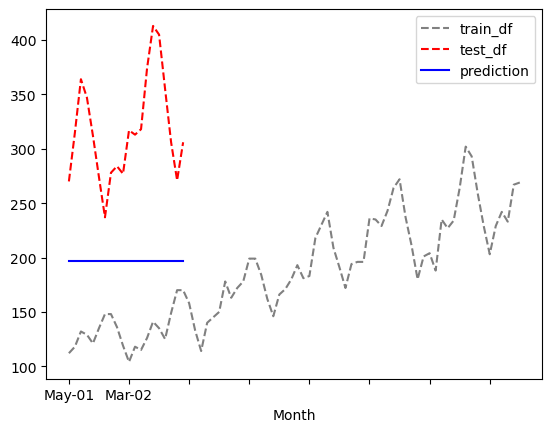

In [47]:
train_df['Passengers'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Passengers'].plot(style='--', color='r', legend=True, label='test_df')
test_df['lstm_pred'].plot(color='b', legend=True, label='prediction')